Code for the figures, where an image is restored from a fraction of pixels (fig. 7 bottom, fig. 14 of supmat).

# Import libs

In [6]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models.resnet import ResNet
from models.unet import UNet
from models.skip import skip
from models import get_net
import torch
import torch.optim
from skimage.measure import compare_psnr

from utils.inpainting_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
imsize=-1
dim_div_by = 64
dtype = torch.cuda.FloatTensor

# Choose figure

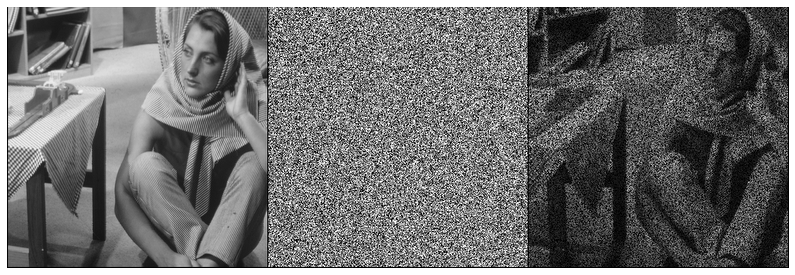

In [7]:
# fig. 7 (bottom)
f = './data/restoration/barbara.png'

# fig. 14 of supmat
# f = './data/restoration/kate.png'


img_pil, img_np = get_image(f, imsize)

if 'barbara' in f:
    img_np = nn.ReflectionPad2d(1)(np_to_torch(img_np))[0].numpy()
    img_pil = np_to_pil(img_np)
    
    img_mask = get_bernoulli_mask(img_pil, 0.50)
    img_mask_np = pil_to_np(img_mask)
elif 'kate' in f:
    img_mask = get_bernoulli_mask(img_pil, 0.98)

    img_mask_np = pil_to_np(img_mask)
    img_mask_np[1] = img_mask_np[0]
    img_mask_np[2] = img_mask_np[0]
else:
    assert False
    

img_masked = img_np * img_mask_np

mask_var = np_to_torch(img_mask_np).type(dtype)

plot_image_grid([img_np, img_mask_np, img_mask_np * img_np], 3,11);

# Set up everything

In [8]:
show_every=50
figsize=5
pad = 'reflection' # 'zero'
INPUT = 'noise'
input_depth = 32
OPTIMIZER = 'adam'
OPT_OVER =  'net'
# if 'barbara' in f:
#     OPTIMIZER = 'adam'
    
#     LR = 0.001
#     num_iter = 11000
#     reg_noise_std = 0.03
    
#     NET_TYPE = 'skip'
#     net = get_net(input_depth, 'skip', pad, n_channels=1,
#                   skip_n33d=128, 
#                   skip_n33u=128, 
#                   skip_n11=4, 
#                   num_scales=5,
#                   upsample_mode='bilinear').type(dtype)
# elif 'kate' in f:
#     OPT_OVER = 'net'
#     num_iter = 1000
#     LR = 0.01
#     reg_noise_std = 0.00
        
#     net = skip(input_depth, 
#                img_np.shape[0], 
#                num_channels_down = [16, 32, 64, 128, 128],
#                num_channels_up   = [16, 32, 64, 128, 128],
#                num_channels_skip =    [0, 0, 0, 0, 0],   
#                filter_size_down = 3, filter_size_up = 3, filter_skip_size=1,
#                upsample_mode='bilinear', 
#                downsample_mode='avg',
#                need_sigmoid=True, need_bias=True, pad=pad).type(dtype)
    
    
nchan=96
# net = get_net(input_depth, 'skip', pad,
#               skip_n33d=nchan, 
#               skip_n33u=nchan, 
#               skip_n11=4, 
#               num_scales=5,
#               upsample_mode='bilinear').type(dtype)

nchan = 32 #32
input_depth = 3
nblocks=3
LR = 0.001
num_iter = 1100
# from models.decp_skip import decp_skip
net = skip(input_depth, 1, num_channels_down = [nchan]*nblocks, 
                        num_channels_up   = [nchan]*nblocks,
                        num_channels_skip = [4]*nblocks, 
                        upsample_mode=['nearest', 'nearest', 'bilinear', 'bilinear', 'bilinear'], 
                        need_sigmoid=True, need_bias=True, pad=pad).type(dtype)
# Losses
# Loss
mse = torch.nn.MSELoss().type(dtype)
img_var = np_to_torch(img_np).type(dtype)

#nn.init.xavier_uniform_(net)
# net_input = get_noise(input_depth, INPUT, img_np.shape[1:]).type(dtype).detach()
net_input =img_var.clone()

In [9]:
def _init_dcvx_parameters(net_to_dcvx):
    # parameters = [p for p in self.image_net.named_parameters()] + \
    #              [p for p in self.mask_net.named_parameters()]
    #     net_to_dcvx = [self.left_net,self.right_net]
    # if self._is_learning_ambient():
    #     net_to_dcvx.append(self.ambient_net)

    # set_trace()
    parameters = list()
    for net in net_to_dcvx:
        # for name, p  in net.named_parameters():
        #     print(name, end=' ')
        layer_id = 0
        # set_trace()
        for name, p  in net.named_parameters():
            layer_id +=1
            if "weight" in name and layer_id>7 and p.dim()>1:
                parameters.append(p)
                print(name)
    return parameters

def dcvx(parameters):
    neg_weight_reg  = 0.0 
    #parameters =self.dcvx_parameters
    for p in parameters:
        neg_weight_reg += torch.norm(p[p<0])
    return neg_weight_reg

dcvx_ = 1
dcvx_coeff= 0.00001
# if 'lib' in img_path:
#     dcvx_coeff= 0.00002
parameters = _init_dcvx_parameters([net])+[net_input]
stop_dcvx = 0

1.1.4.1.weight
1.1.7.1.0.1.1.weight
1.1.7.1.1.1.1.weight
1.1.7.1.1.4.1.weight
1.1.7.1.1.7.1.0.1.1.weight
1.1.7.1.1.7.1.1.1.1.weight
1.1.7.1.1.7.1.1.4.1.weight
1.1.7.1.1.7.3.1.weight
1.1.7.1.1.7.6.1.weight
1.1.7.3.1.weight
1.1.7.6.1.weight
3.1.weight
6.1.weight
9.1.weight


# Main loop

In [10]:
def closure():

    global i, psrn_masked_last, last_net, net_input, dcvx_, stop_dcvx
    
    #if reg_noise_std > 0:net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)

    total_loss = mse(out * mask_var, img_var * mask_var)
    if dcvx_ and not stop_dcvx:
        dcvx_loss = dcvx(parameters)*dcvx_coeff
        if i%50==0:
            print("dcvx_loss:"+str(dcvx_loss.data.cpu())+ " total_loss:"+str(total_loss.data.cpu()))
            if dcvx_loss.data.cpu()> total_loss.data.cpu():
                stop_dcvx = 1
        #total_loss += dcvx_loss
            
        dcvx_loss += total_loss
        dcvx_loss.backward()
    else:
        total_loss.backward()
    
    psrn_masked = compare_psnr(img_masked, out.detach().cpu().numpy()[0] * img_mask_np) 
    psrn = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 

    print ('Iteration %05d    Loss %f PSNR_masked %f PSNR %f' % (i, total_loss.item(), psrn_masked, psrn),'\r', end='')
    
    
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        
        # Backtracking
        if psrn_masked - psrn_masked_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.cpu() for x in net.parameters()]
            psrn_masked_last = psrn_masked



        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)

    i += 1

    return total_loss

# Init globals 
last_net = None
psrn_masked_last = 0
i = 0

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

# Run
OPT_OVER =  'net'
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR=LR, num_iter=100)

OPT_OVER =  'net'
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR=LR, num_iter=num_iter)

Starting optimization with ADAM


RuntimeError: Given groups=1, weight of size [4, 3, 1, 1], expected input[1, 1, 514, 514] to have 3 channels, but got 1 channels instead

In [ ]:
out_np = torch_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1), img_np], factor=13);